In [186]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:

try: 
    from google.colab.patches import cv2_imshow
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError: 
    print("not using colab.")


not using colab.


# Setting up PHD Filter
This portion pulls and builds the filter code. If you have the filter code pulled, make sure to navigate "cd" into that directory.

In [ ]:
!git clone https://github.com/MobileRoboticistsW21/PHD-object-traking.git

In [ ]:
%cd PHD-object-traking/

In [ ]:
!git checkout main   # can change this to main if branch is merged 
!git pull

In [ ]:
%cd /content/PHD-object-traking/
!bash setup.sh

### Notice!
The cell below runs the filter which will prompt you for the location of the data file you would like to process. Sample data is provided. Try ../data/first_20_frame_optical_res.json

In [ ]:
!mkdir build
%cd build
!cmake ..
!make phd_json_dump
!./phd_json_dump
%cd ../

# Visualization and Testing

If current directory is the that of the filter repository, all that needs to be set is the VIDEO_NAME and image_dir.

In [202]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import cv2
import numpy as np

In [203]:
VIDEO_NAME = "MOT16-11"
images_dir = os.path.abspath("../" + VIDEO_NAME + "_images")
# images_dir = None # "/content/drive/My Drive/Mask_RCNN_stuff/" + VIDEO_NAME
filtered_data_dir = os.path.abspath("data/output/filtered_"+VIDEO_NAME+"_optical_flow_res.json")
detection_data_dir = os.path.abspath("data/" + VIDEO_NAME + "_optical_flow_res.json")
ground_truth_dir = ""

In [199]:
try:
    with open(detection_data_dir, encoding='UTF-8', errors='ignore') as inputFile:
        data_input = json.load(inputFile)
except: print("Cannot find sensor data!")

try:
    with open(filtered_data_dir, encoding='UTF-8', errors='ignore') as inputFile:
        data_out = json.load(inputFile)
except: print("Cannot find filtered data!")

if images_dir:
    try:
        images = os.listdir(images_dir)
        images.sort()
        assert(len(images) > 0)
    except:
        print("No images were found!")

<ipython-input-200-7a5545794159>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


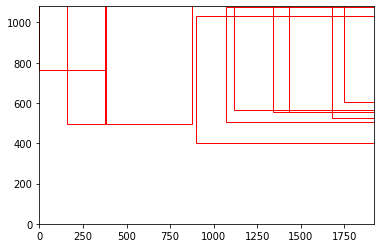

In [200]:
from python_utils.box_vis_utils import xywh_to_corners

disp_frames = 1
for i in range(min(disp_frames, len(data_out))):
    bbs = data_out[i]['bb']
    plt.clf(); plt.xlim(0, 1920); plt.ylim(0, 1080)
    ax = plt.axes()
    for bb in bbs:
        c = xywh_to_corners([bb])[0]
        rect = patches.Rectangle((c[0], c[1]), c[2], c[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # plt.show()
    plt.pause(0.25)


In [204]:
# Miracle + Mingshuo's code to visualize Genertated & Mask RCNN Boxes with images.
from python_utils.box_vis_utils import xywh_to_corners

def overlay_boxes_on_images(num_frames = None, mode="save", path=None):
  '''
  mode can be "save" or "show"
  num_frames can be set to None To include all frames
  '''
  assert((mode == "save" and path != None) or mode == "show")
  for idx, (image_name,in_data, gen_data) in enumerate(zip(images[0:-2], data_input, data_out)):
    image = cv2.imread(os.path.join(images_dir, image_name))
    data_tlbr_in = xywh_to_corners(in_data['bb'])
    data_tlbr_gen = xywh_to_corners(gen_data['bb'])
    for bb in data_tlbr_in:
      alpha = 0.3
      overlay = image.copy()
      cv2.rectangle(overlay, (bb[0],bb[1]), (bb[2], bb[3]),(255,0,0), -1)
      cv2.addWeighted(overlay, alpha, image, 1 - alpha,0, image)
    for bb in data_tlbr_gen:
      cv2.rectangle(image, (bb[0],bb[1]), (bb[2], bb[3]),(0,255,0), 5)


    if mode == "show":
      # cv2.imshow(image_name, image)
      # cv2.waitKey(0) 
      # cv2.destroyAllWindows()
      plt.clf()
      plt.imshow(image)
      plt.pause(0.25)
    if mode == "save":
      print("\rSaving Image #",image_name, end='')
      cv2.imwrite((path + "/" + VIDEO_NAME + '_' + image_name), image)

    if num_frames and num_frames < idx: break 

In [205]:
# Combine image frames into a video with original resolution
import cv2
import numpy as np

def video_from_images(path):
  image_file_names = os.listdir(path)
  image_file_names = [x for x in image_file_names if x.startswith(VIDEO_NAME)]
  image_file_names.sort()
  assert(len(image_file_names) > 0)

  img = cv2.imread(os.path.join(path, image_file_names[0]))
  height,width,layers = img.shape

  fourcc = fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
  fps = 25

  video=cv2.VideoWriter(path + "/" + VIDEO_NAME+'_phd_filter_viz_video_short.mp4', \
                        fourcc, fps,(width,height))

  for img_name in image_file_names:
    img = cv2.imread(os.path.join(path, img_name))
    print("\rConstructing Video. Adding img: ", img_name, end='')
    video.write(img)
  cv2.destroyAllWindows()
  video.release()

In [206]:
!mkdir data/output/temp_images_folder
output_img_dir = os.path.abspath("data/output/temp_images_folder")

# overlay_boxes_on_images(num_frames=5, mode="show", path=output_img_dir)

overlay_boxes_on_images(num_frames=None, mode="save", path=output_img_dir)
video_from_images(output_img_dir)

print("\nDone!")

mkdir: cannot create directory ‘data/output/temp_images_folder’: File exists
writing in image#  MOT16-11_phd_filter_viz_video_short.mp4
Done!


In [207]:
# Clean up images!
for f in os.listdir(output_img_dir):
    if f.endswith(".jpg"): 
        os.remove(os.path.join(output_img_dir, f))

# Post processing and tuning

## Assigning IDs
In its current state the filter does not track IDs. Evaluation code for MOT expects IDs. This code is a workaround so we can run evaluation.

In [173]:
from python_utils.id_assigner import assign_ids_postfact
data_with_ids_dir = 'data/output/filtered_' + VIDEO_NAME + '_with_ids'
data = assign_ids_postfact(data_out)
with open(data_with_ids_dir + '.json', 'w') as outfile:
    json.dump(data, outfile, indent=4)

AxisError: axis 1 is out of bounds for array of dimension 1

## Formatting as txt
Adjusts text type and format to allow running the evaluation code provided by MOT

In [165]:
from python_utils.json_to_txt import json_to_txt
json_to_txt(data_with_ids_dir)